In [14]:
# Install necessary libraries
!pip install torch datasets matplotlib

# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt

In [15]:
# Initialize tokenizer (simple tokenization for this example)
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [16]:
# Load IMDb dataset and split into train and test sets
imdb = load_dataset("imdb", split="train[:10000]").train_test_split(test_size=0.2)
train_data = imdb['train']
test_data = imdb['test']



In [17]:
# Custom dataset class
class IMDbDataset(Dataset):
    def __init__(self, data, tokenizer, max_len):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        review = str(self.data[index]['text'])
        label = self.data[index]['label']
        
        tokens = self.tokenizer(review)
        tokens = tokens[:self.max_len] + ['<pad>'] * (self.max_len - len(tokens))
        token_ids = [vocab.get(token, vocab['<unk>']) for token in tokens]
        
        return {
            'review_text': review,
            'input_ids': torch.tensor(token_ids, dtype=torch.long),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Build vocabulary
def build_vocab(data, tokenizer, min_freq=1):
    freq = {}
    for review in data['text']:
        for token in tokenizer(review):
            if token in freq:
                freq[token] += 1
            else:
                freq[token] = 1
    vocab = {token: i+2 for i, (token, count) in enumerate(freq.items()) if count >= min_freq}
    vocab['<pad>'] = 0
    vocab['<unk>'] = 1
    return vocab



In [18]:
# Parameters
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 3
LEARNING_RATE = 2e-5

# Build vocabulary
vocab = build_vocab(train_data, word_tokenize)

# Create data loaders
train_dataset = IMDbDataset(train_data, word_tokenize, MAX_LEN)
test_dataset = IMDbDataset(test_data, word_tokenize, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [19]:
# Define Transformer model from scratch
class Transformer(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, max_seq_length, num_classes):
        super(Transformer, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = nn.Parameter(torch.zeros(1, max_seq_length, d_model))
        self.transformer = nn.Transformer(d_model=d_model, nhead=nhead, num_encoder_layers=num_encoder_layers,
                                          num_decoder_layers=num_decoder_layers, dim_feedforward=dim_feedforward)
        self.fc = nn.Linear(d_model, num_classes)
    
    def forward(self, src, src_mask=None):
        src = self.embedding(src) + self.positional_encoding[:, :src.size(1), :]
        src = src.permute(1, 0, 2)  # Transformer expects sequence first
        output = self.transformer(src, src, src_mask, src_mask)
        output = output.permute(1, 0, 2)  # Convert back to batch first
        output = self.fc(output[:, 0, :])
        return output

In [20]:
# Initialize the model, loss function, and optimizer
vocab_size = len(vocab)
d_model = 128
nhead = 8
num_encoder_layers = 3
num_decoder_layers = 3
dim_feedforward = 512
max_seq_length = MAX_LEN
num_classes = 2

model = Transformer(vocab_size, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, max_seq_length, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [21]:
# Training loop
def train_epoch(model, data_loader, criterion, optimizer, device):
    model = model.train()
    losses = []
    correct_predictions = 0
    
    for data in data_loader:
        input_ids = data['input_ids'].to(device)
        labels = data['label'].to(device)
        
        outputs = model(input_ids)
        _, preds = torch.max(outputs, dim=1)
        loss = criterion(outputs, labels)
        
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)

# Evaluation loop
def eval_model(model, data_loader, criterion, device):
    model = model.eval()
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for data in data_loader:
            input_ids = data['input_ids'].to(device)
            labels = data['label'].to(device)
            
            outputs = model(input_ids)
            _, preds = torch.max(outputs, dim=1)
            loss = criterion(outputs, labels)
            
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())
    
    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)

# Variables to store accuracy and loss
train_accuracies = []
train_losses = []
val_accuracies = []
val_losses = []

# Training the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [22]:
# Variables to store accuracy and loss
train_accuracies = []
train_losses = []
val_accuracies = []
val_losses = []

# Training the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [23]:
device

device(type='cuda')

In [24]:
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    
    train_acc, train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_acc, val_loss = eval_model(model, test_loader, criterion, device)
    
    train_accuracies.append(train_acc.cpu().item())
    train_losses.append(train_loss)
    val_accuracies.append(val_acc.cpu().item())
    val_losses.append(val_loss)
    print(f'Epoch {epoch + 1} -- Train Accuracy: {train_acc:.4f} -- Train Loss: {train_loss:.4f} -- Val Accuracy: {val_acc:.4f} -- Val Loss: {val_loss:.4f}')

print("Training complete")

Epoch 1/3
----------
Epoch 1 -- Train Accuracy: 0.9998 -- Train Loss: 0.0076 -- Val Accuracy: 1.0000 -- Val Loss: 0.0003
Epoch 2/3
----------
Epoch 2 -- Train Accuracy: 1.0000 -- Train Loss: 0.0004 -- Val Accuracy: 1.0000 -- Val Loss: 0.0002
Epoch 3/3
----------
Epoch 3 -- Train Accuracy: 1.0000 -- Train Loss: 0.0002 -- Val Accuracy: 1.0000 -- Val Loss: 0.0001
Training complete


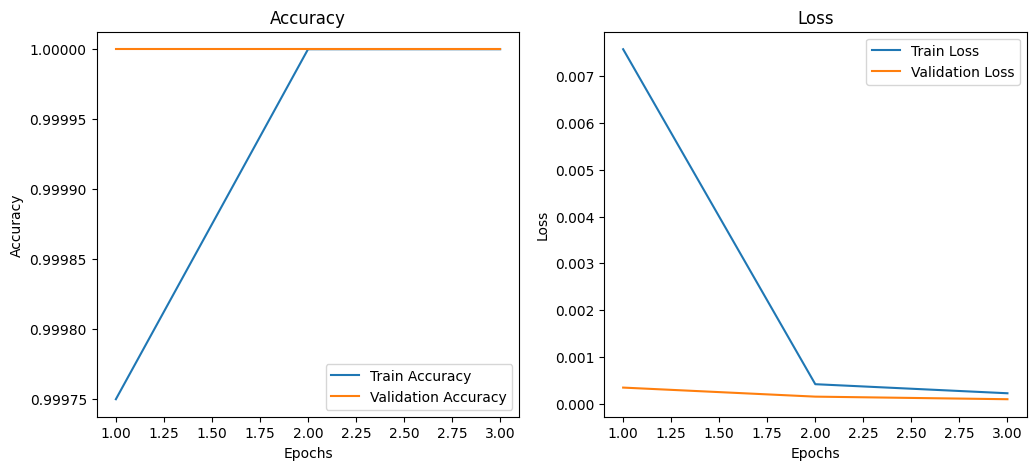

In [25]:
# Plot accuracy and loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, EPOCHS + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), train_losses, label='Train Loss')
plt.plot(range(1, EPOCHS + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')

plt.show()